In [1]:

import os, shutil
from glob import glob
import numpy as np
import pandas as pd
from natsort import natsorted
import seaborn as sns
from tqdm import tqdm, trange
import matplotlib.pyplot as plt


In [2]:

in_dir = "out01_tms_induced_respose/"
in_dir2 = "data_subject_info/"

out_dir = "out02_correlation_and_scatterplot_common_mask/"
in_file_name = "HRF_tms_induced_response_common_mask_Fp_individual_mask.csv"

if not os.path.exists(out_dir):
    os.mkdir(out_dir)
    
complete_df = pd.read_csv(in_dir + in_file_name)

subject_info = pd.read_csv(in_dir2 + "age_gender_edu.txt", sep = ',')
intensity_suds = pd.read_csv(in_dir2 + "intensity_suds.csv", sep = ',')
scalp_dist = pd.read_csv(in_dir2 + "dist_to_scalp.csv", sep = ',')
print(list(scalp_dist['site'].drop_duplicates()))


['L-FP', 'R-FP', 'L-aMFG', 'R-aMFG', 'L-pMFG', 'R-pMFG', 'R-IFJ', 'R-FEF', 'R-M1', 'R-preSMA', 'R-IPL']


In [3]:
tms_sites = ["L_Fp","R_Fp","L_aMFG","R_aMFG","L_pMFG","R_pMFG","R_IFJ","R_FEF","R_M1","R_preSMA","R_IPL"]

# scalp_dist['site'] = scalp_dist['site'].str.replace('-', '_')
scalp_dist['site'].replace(list(scalp_dist['site'].drop_duplicates()), tms_sites, inplace = True)
# df['range'].str.replace(',','-')

# reformat columns in intensity_suds:
intensity_suds = pd.melt(intensity_suds, id_vars=['idall', 'MT', 'intensity'], value_vars = tms_sites,
                         var_name = 'suds_site', value_name = 'suds')

data = subject_info.merge(complete_df, left_on = 'cc_post_intake_id', right_on = 'subject')
data = data.merge(intensity_suds, how = 'left', 
                  left_on = ['cc_post_intake_id', 'site'], right_on = ['idall', 'suds_site'])

data = data.merge(scalp_dist, how = 'left', 
                  left_on = ['subject', 'site'], right_on = ['subject', 'site'])

data.drop(labels = ['inputfile', 'idall', 'cc_post_intake_id', 'suds_site'], axis = 1, inplace = True)
data.replace({'gender': {1: "male", 2: "female"}}, inplace = True)
data


,gender,age,yrs_of_edu,Unnamed: 0,subject,site,group,tms_site_response_6mm,tms_site_response_10mm,tms_site_response_14mm,tms_site_response_14-10mm,tms_site_response_10-6mm,MT,intensity,suds,scalp_dist
0,female,45,18,0,1001,L_Fp,NTHC,0.439684,0.456288,0.395807,0.354767,0.462649,62.0,74.0,10.0,14.749354
1,female,45,18,300,1001,R_Fp,NTHC,0.278052,0.265166,0.243850,0.230372,0.260594,62.0,74.0,7.0,16.614293
2,female,45,18,142,1001,L_pMFG,NTHC,-0.444990,-0.412696,-0.310918,-0.256227,-0.406768,62.0,74.0,5.0,13.038824
3,female,45,18,222,1001,R_FEF,NTHC,-0.311842,-0.273876,-0.276212,-0.277628,-0.262818,62.0,74.0,2.0,17.079627
4,female,45,18,496,1001,R_M1,NTHC,-0.916150,-1.146695,-1.232267,-1.289315,-1.221521,62.0,74.0,1.0,15.276347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,male,22,14,495,2108,R_IPL,TEHC,0.644515,1.131969,1.284253,1.393884,1.307835,NaN,100.0,5.0,14.361543
788,male,22,14,574,2108,R_M1,TEHC,0.210817,0.194829,0.193421,0.192483,0.189640,NaN,100.0,15.0,18.975313
789,male,22,14,654,2108,R_aMFG,TEHC,0.058481,-0.014030,-0.102940,-0.160327,-0.035552,NaN,100.0,20.0,13.567683
790,male,22,14,733,2108,R_pMFG,TEHC,0.590151,0.451812,0.335860,0.267050,0.416303,NaN,100.0,20.0,14.366030


In [4]:
## pairwise correlation:
from scipy.stats import pearsonr
from IPython.display import display

corr_x1 = ['tms_site_response_6mm',
           'tms_site_response_10mm', 'tms_site_response_14mm', 
           'tms_site_response_14-10mm', 'tms_site_response_10-6mm']

corr_x2 = ['age', 'yrs_of_edu', 'intensity', 'MT', 'scalp_dist', 'suds']
tms_sites = ["L_Fp","R_Fp","L_aMFG","R_aMFG","L_pMFG","R_pMFG","R_IFJ","R_FEF","R_M1","R_preSMA","R_IPL"]

for x1 in corr_x1:
    row_index = pd.MultiIndex.from_tuples([(i , j) for i in corr_x2 for j in ["Pearson's r", 'p value']])
    result = pd.DataFrame(index = row_index, columns = tms_sites)
    for site in tms_sites:
        for x2 in corr_x2:
            x1_val = data.loc[data['site'] == site, x1].values
            x2_val = data.loc[data['site'] == site, x2].values
            
            idx_nan = np.isnan(x1_val) | np.isnan(x2_val)
            r, p = pearsonr(x1_val[~idx_nan], x2_val[~idx_nan])
            result.loc[(x2, "Pearson's r"), site] = "%.3f" % r
            result.loc[(x2, 'p value'), site] = "%.3f" % p + ('*' if p < .05 else '')
            
            result.to_csv(out_dir + 'correlation_' + x1 + '.csv')
    print(x1)
    display(result)

tms_site_response_6mm


L_Fp    R_Fp  L_aMFG R_aMFG  L_pMFG  R_pMFG   R_IFJ  \
age        Pearson's r  -0.179   0.142   0.214  0.122   0.047   0.023  -0.038   
           p value       0.205   0.325   0.062  0.283   0.683   0.838   0.749   
yrs_of_edu Pearson's r  -0.250   0.063   0.136  0.165   0.117   0.043  -0.009   
           p value       0.074   0.666   0.238  0.147   0.306   0.707   0.937   
intensity  Pearson's r  -0.176  -0.082  -0.166  0.073  -0.088   0.026   0.221   
           p value       0.213   0.572   0.149  0.525   0.443   0.820   0.057   
MT         Pearson's r  -0.154  -0.144  -0.116  0.057   0.003   0.100   0.145   
           p value       0.369   0.424   0.396  0.669   0.981   0.451   0.291   
scalp_dist Pearson's r  -0.084  -0.077  -0.095  0.113  -0.187   0.141   0.017   
           p value       0.552   0.596   0.439  0.347   0.124   0.244   0.895   
suds       Pearson's r   0.316  -0.027   0.015  0.142  -0.156  -0.044  -0.102   
           p value      0.023*   0.853   0.894  0.216   0.171   0.699   0.386   

                         R_FEF    R_M1 R_preSMA   R_IPL  
age        Pearson's r  -0.067  -0.022   -0.126   0.086  
           p value       0.561   0.845    0.319   0.550  
yrs_of_edu Pearson's r   0.080  -0.191    0.045   0.078  
           p value       0.488   0.093    0.722   0.586  
intensity  Pearson's r   0.053  -0.042   -0.065  -0.204  
           p value       0.644   0.716    0.609   0.151  
MT         Pearson's r  -0.037  -0.033   -0.120  -0.116  
           p value       0.784   0.803    0.418   0.514  
scalp_dist Pearson's r  -0.186  -0.128   -0.019  -0.192  
           p value       0.131   0.292    0.886   0.212  
suds       Pearson's r   0.010   0.018   -0.034  -0.174  
           p value       0.933   0.878    0.790   0.283

tms_site_response_10mm


L_Fp    R_Fp  L_aMFG R_aMFG  L_pMFG  R_pMFG   R_IFJ  \
age        Pearson's r  -0.136   0.076   0.193  0.131   0.057  -0.026  -0.033   
           p value       0.336   0.579   0.092  0.248   0.616   0.823   0.782   
yrs_of_edu Pearson's r  -0.277   0.076   0.133  0.163   0.096   0.048   0.015   
           p value      0.047*   0.580   0.248  0.152   0.401   0.674   0.900   
intensity  Pearson's r  -0.121  -0.012  -0.141  0.055  -0.067   0.009   0.208   
           p value       0.392   0.931   0.220  0.632   0.559   0.935   0.073   
MT         Pearson's r  -0.074   0.061  -0.096  0.027   0.036   0.087   0.118   
           p value       0.668   0.721   0.481  0.836   0.787   0.511   0.393   
scalp_dist Pearson's r  -0.133  -0.065  -0.100  0.159  -0.122   0.077   0.027   
           p value       0.349   0.638   0.417  0.187   0.319   0.529   0.828   
suds       Pearson's r   0.322   0.007   0.032  0.167  -0.138  -0.014  -0.134   
           p value      0.020*   0.962   0.783  0.143   0.224   0.904   0.256   

                         R_FEF    R_M1 R_preSMA   R_IPL  
age        Pearson's r  -0.038  -0.021   -0.118   0.092  
           p value       0.744   0.856    0.355   0.521  
yrs_of_edu Pearson's r   0.103  -0.145    0.035   0.124  
           p value       0.372   0.202    0.783   0.385  
intensity  Pearson's r   0.044  -0.014   -0.100  -0.195  
           p value       0.702   0.904    0.432   0.170  
MT         Pearson's r  -0.028  -0.039   -0.148  -0.132  
           p value       0.834   0.771    0.317   0.457  
scalp_dist Pearson's r  -0.181  -0.090    0.017  -0.137  
           p value       0.143   0.459    0.902   0.374  
suds       Pearson's r  -0.006  -0.000   -0.031  -0.178  
           p value       0.962   0.997    0.808   0.271

tms_site_response_14mm


L_Fp    R_Fp  L_aMFG  R_aMFG  L_pMFG  R_pMFG  \
age        Pearson's r  -0.107   0.035   0.179   0.142   0.082  -0.025   
           p value       0.452   0.802   0.119   0.211   0.474   0.825   
yrs_of_edu Pearson's r  -0.287   0.066   0.125   0.162   0.095   0.052   
           p value      0.039*   0.630   0.278   0.153   0.407   0.647   
intensity  Pearson's r  -0.099  -0.023  -0.125   0.006  -0.047  -0.006   
           p value       0.485   0.866   0.280   0.961   0.684   0.957   
MT         Pearson's r  -0.043   0.044  -0.100  -0.024   0.067   0.062   
           p value       0.801   0.797   0.464   0.855   0.612   0.639   
scalp_dist Pearson's r  -0.144  -0.072  -0.092   0.162  -0.024   0.040   
           p value       0.308   0.600   0.455   0.177   0.848   0.743   
suds       Pearson's r   0.317  -0.003   0.051   0.149  -0.105   0.014   
           p value      0.022*   0.986   0.663   0.192   0.359   0.906   

                         R_IFJ   R_FEF    R_M1 R_preSMA   R_IPL  
age        Pearson's r  -0.013   0.009  -0.002   -0.121   0.077  
           p value       0.911   0.938   0.986    0.342   0.591  
yrs_of_edu Pearson's r   0.050   0.131  -0.120    0.025   0.145  
           p value       0.668   0.255   0.293    0.843   0.310  
intensity  Pearson's r   0.180   0.025   0.019   -0.095  -0.181  
           p value       0.121   0.830   0.866    0.457   0.205  
MT         Pearson's r   0.080  -0.013  -0.020   -0.153  -0.110  
           p value       0.560   0.926   0.880    0.299   0.536  
scalp_dist Pearson's r   0.035  -0.175  -0.069    0.049  -0.112  
           p value       0.778   0.157   0.571    0.717   0.470  
suds       Pearson's r  -0.145  -0.012  -0.017   -0.007  -0.210  
           p value       0.217   0.916   0.885    0.955   0.193

tms_site_response_14-10mm


L_Fp    R_Fp  L_aMFG  R_aMFG  L_pMFG  R_pMFG  \
age        Pearson's r  -0.091   0.014   0.168   0.145   0.095  -0.025   
           p value       0.520   0.920   0.143   0.202   0.406   0.830   
yrs_of_edu Pearson's r  -0.281   0.058   0.119   0.154   0.091   0.054   
           p value      0.043*   0.674   0.304   0.174   0.427   0.638   
intensity  Pearson's r  -0.083  -0.022  -0.114  -0.036  -0.032  -0.016   
           p value       0.558   0.872   0.324   0.753   0.780   0.889   
MT         Pearson's r  -0.022   0.048  -0.100  -0.070   0.086   0.045   
           p value       0.899   0.776   0.461   0.597   0.519   0.733   
scalp_dist Pearson's r  -0.147  -0.070  -0.085   0.158   0.041   0.015   
           p value       0.298   0.614   0.491   0.187   0.738   0.904   
suds       Pearson's r   0.308  -0.005   0.059   0.127  -0.079   0.031   
           p value      0.026*   0.974   0.607   0.267   0.487   0.786   

                         R_IFJ   R_FEF    R_M1 R_preSMA   R_IPL  
age        Pearson's r   0.002   0.041   0.012   -0.122   0.063  
           p value       0.990   0.721   0.917    0.339   0.663  
yrs_of_edu Pearson's r   0.075   0.147  -0.099    0.019   0.156  
           p value       0.522   0.202   0.383    0.880   0.274  
intensity  Pearson's r   0.155   0.011   0.043   -0.090  -0.163  
           p value       0.183   0.927   0.704    0.477   0.254  
MT         Pearson's r   0.052  -0.002  -0.006   -0.155  -0.088  
           p value       0.706   0.990   0.965    0.293   0.621  
scalp_dist Pearson's r   0.040  -0.166  -0.052    0.068  -0.088  
           p value       0.747   0.179   0.666    0.615   0.569  
suds       Pearson's r  -0.150  -0.017  -0.029    0.007  -0.228  
           p value       0.201   0.886   0.805    0.956   0.158

tms_site_response_10-6mm


L_Fp    R_Fp  L_aMFG R_aMFG  L_pMFG  R_pMFG   R_IFJ  \
age        Pearson's r  -0.128   0.077   0.188  0.133   0.059  -0.039  -0.030   
           p value       0.366   0.578   0.101  0.243   0.605   0.735   0.797   
yrs_of_edu Pearson's r  -0.277   0.077   0.132  0.160   0.091   0.049   0.023   
           p value      0.046*   0.577   0.254  0.159   0.427   0.670   0.844   
intensity  Pearson's r  -0.106  -0.011  -0.136  0.048  -0.062   0.005   0.200   
           p value       0.453   0.935   0.239  0.677   0.589   0.968   0.085   
MT         Pearson's r  -0.049   0.067  -0.092  0.016   0.042   0.082   0.106   
           p value       0.775   0.693   0.499  0.902   0.749   0.539   0.441   
scalp_dist Pearson's r  -0.141  -0.064  -0.100  0.171  -0.107   0.057   0.031   
           p value       0.320   0.642   0.418  0.153   0.383   0.637   0.807   
suds       Pearson's r   0.319   0.005   0.035  0.174  -0.134  -0.005  -0.143   
           p value      0.021*   0.973   0.764  0.127   0.240   0.964   0.225   

                         R_FEF    R_M1 R_preSMA   R_IPL  
age        Pearson's r  -0.027  -0.020   -0.114   0.092  
           p value       0.818   0.862    0.368   0.520  
yrs_of_edu Pearson's r   0.109  -0.128    0.032   0.139  
           p value       0.346   0.259    0.800   0.329  
intensity  Pearson's r   0.040  -0.005   -0.108  -0.186  
           p value       0.729   0.969    0.397   0.190  
MT         Pearson's r  -0.025  -0.041   -0.153  -0.136  
           p value       0.854   0.762    0.298   0.443  
scalp_dist Pearson's r  -0.175  -0.077    0.025  -0.113  
           p value       0.157   0.528    0.851   0.467  
suds       Pearson's r  -0.011  -0.006   -0.030  -0.176  
           p value       0.927   0.956    0.814   0.278

In [5]:
test_variables = ['tms_site_response_6mm',
           'tms_site_response_10mm', 'tms_site_response_14mm', 
           'tms_site_response_14-10mm', 'tms_site_response_10-6mm']

plot_data = pd.melt(data, id_vars = ['subject', 'site', 'gender', 'suds'] + test_variables, 
                    value_vars = ['age', 'yrs_of_edu', 'intensity', 'MT', 'scalp_dist'], 
                    var_name = 'metrics', value_name='values')

plot_data.groupby('metrics')['values'].count()


metrics
MT            581
age           792
intensity     792
scalp_dist    689
yrs_of_edu    792
Name: values, dtype: int64

In [6]:
## scatter plots:
sns.set(rc={'figure.figsize':(5.2 * 11, 5.2 * 6)}, font_scale = 1.15)

from scipy.stats import pearsonr
# we don't need partial correlation this could be eliminated to make the code cleaner
from pingouin import partial_corr 

tms_sites = data['site'].unique()
colors = [sns.xkcd_rgb["black"]] + sns.color_palette("husl", len(tms_sites)).as_hex()
colors = colors[1::2] + colors[2::2] 
scatter_para = {'alpha': 0.7, 's': 30, 'linewidth': 0.2}

def scatter_plot(plot_data, ylabel, method = 'correlation'):
    
    g = sns.lmplot(x = 'values', y = ylabel, hue = 'site', 
                   row = 'site', col = 'metrics', palette = colors, 
                   data = plot_data, fit_reg = True, sharex = False, sharey = True, \
                   scatter_kws=scatter_para, 
                   line_kws = {'lw': 2},
                   x_jitter = .2, order = 1,
                   height=3.27, aspect=1, legend = False)
    
    # compute R squared for each group and cluster:
    column_title = plot_data['metrics'].unique()
    
    x_pos = [18, 12, 71, 48, 7, -5]
    x_lim = [[16, 62], [11.5, 18.5], [69, 102], [46, 85], [6, 25], [-10, 100]]
    
    for col in range(len(column_title)):
        for row in range(len(tms_sites)):
            x = plot_data.loc[(plot_data['site']==tms_sites[row])&(plot_data['metrics']==column_title[col]), 
                              'values'].values
            y = plot_data.loc[(plot_data['site']==tms_sites[row])&(plot_data['metrics']==column_title[col]), 
                              ylabel].values
                        
            if method == 'correlation':
                idx_nan = np.isnan(x) | np.isnan(y)
                r, p = pearsonr(x[~idx_nan], y[~idx_nan])
                label = "$r$ = %.3f, $p$ = %.3f" % (r, p)
                if p < .05:
                    label += '*'
            else: # partial correlation:
                z = plot_data.loc[(plot_data['site']==tms_sites[row])&(plot_data['metrics']==column_title[col]), 
                              'suds'].values
                
                idx_nan = np.isnan(x) | np.isnan(y) | np.isnan(z)
                df = pd.DataFrame({'x': x[~idx_nan], 'y': y[~idx_nan], 'z': z[~idx_nan]})
                res = partial_corr(df, x = 'x', y = 'y', covar = 'z')
                label = "$r$ = %.3f, $p$ = %.3f" % (res['r'], res['p-val'])
                if res['p-val'].values < .05:
                    label += '*'
            
            g.axes[row, col].set_xlim(x_lim[col])
            g.axes[row, col].text(x_pos[col], 2.5, label, fontsize = 13)
            
    return g
       

In [7]:

plot_data = pd.melt(data, id_vars = ['subject', 'site', 'gender'] + test_variables, 
                    value_vars = ['age', 'yrs_of_edu', 'intensity', 'MT', 'scalp_dist', 'suds'], 
                    var_name = 'metrics', value_name='values')

# scatter_plot(plot_data, test_variables[0], 'correlation')


/Users/jingjiang/miniconda3/lib/python3.8/site-packages/seaborn/regression.py:582: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/Users/jingjiang/miniconda3/lib/python3.8/site-packages/seaborn/regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/Users/jingjiang/miniconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/jingjiang/miniconda3/lib/python3.8/site-packages/seaborn/regression.py:582: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)

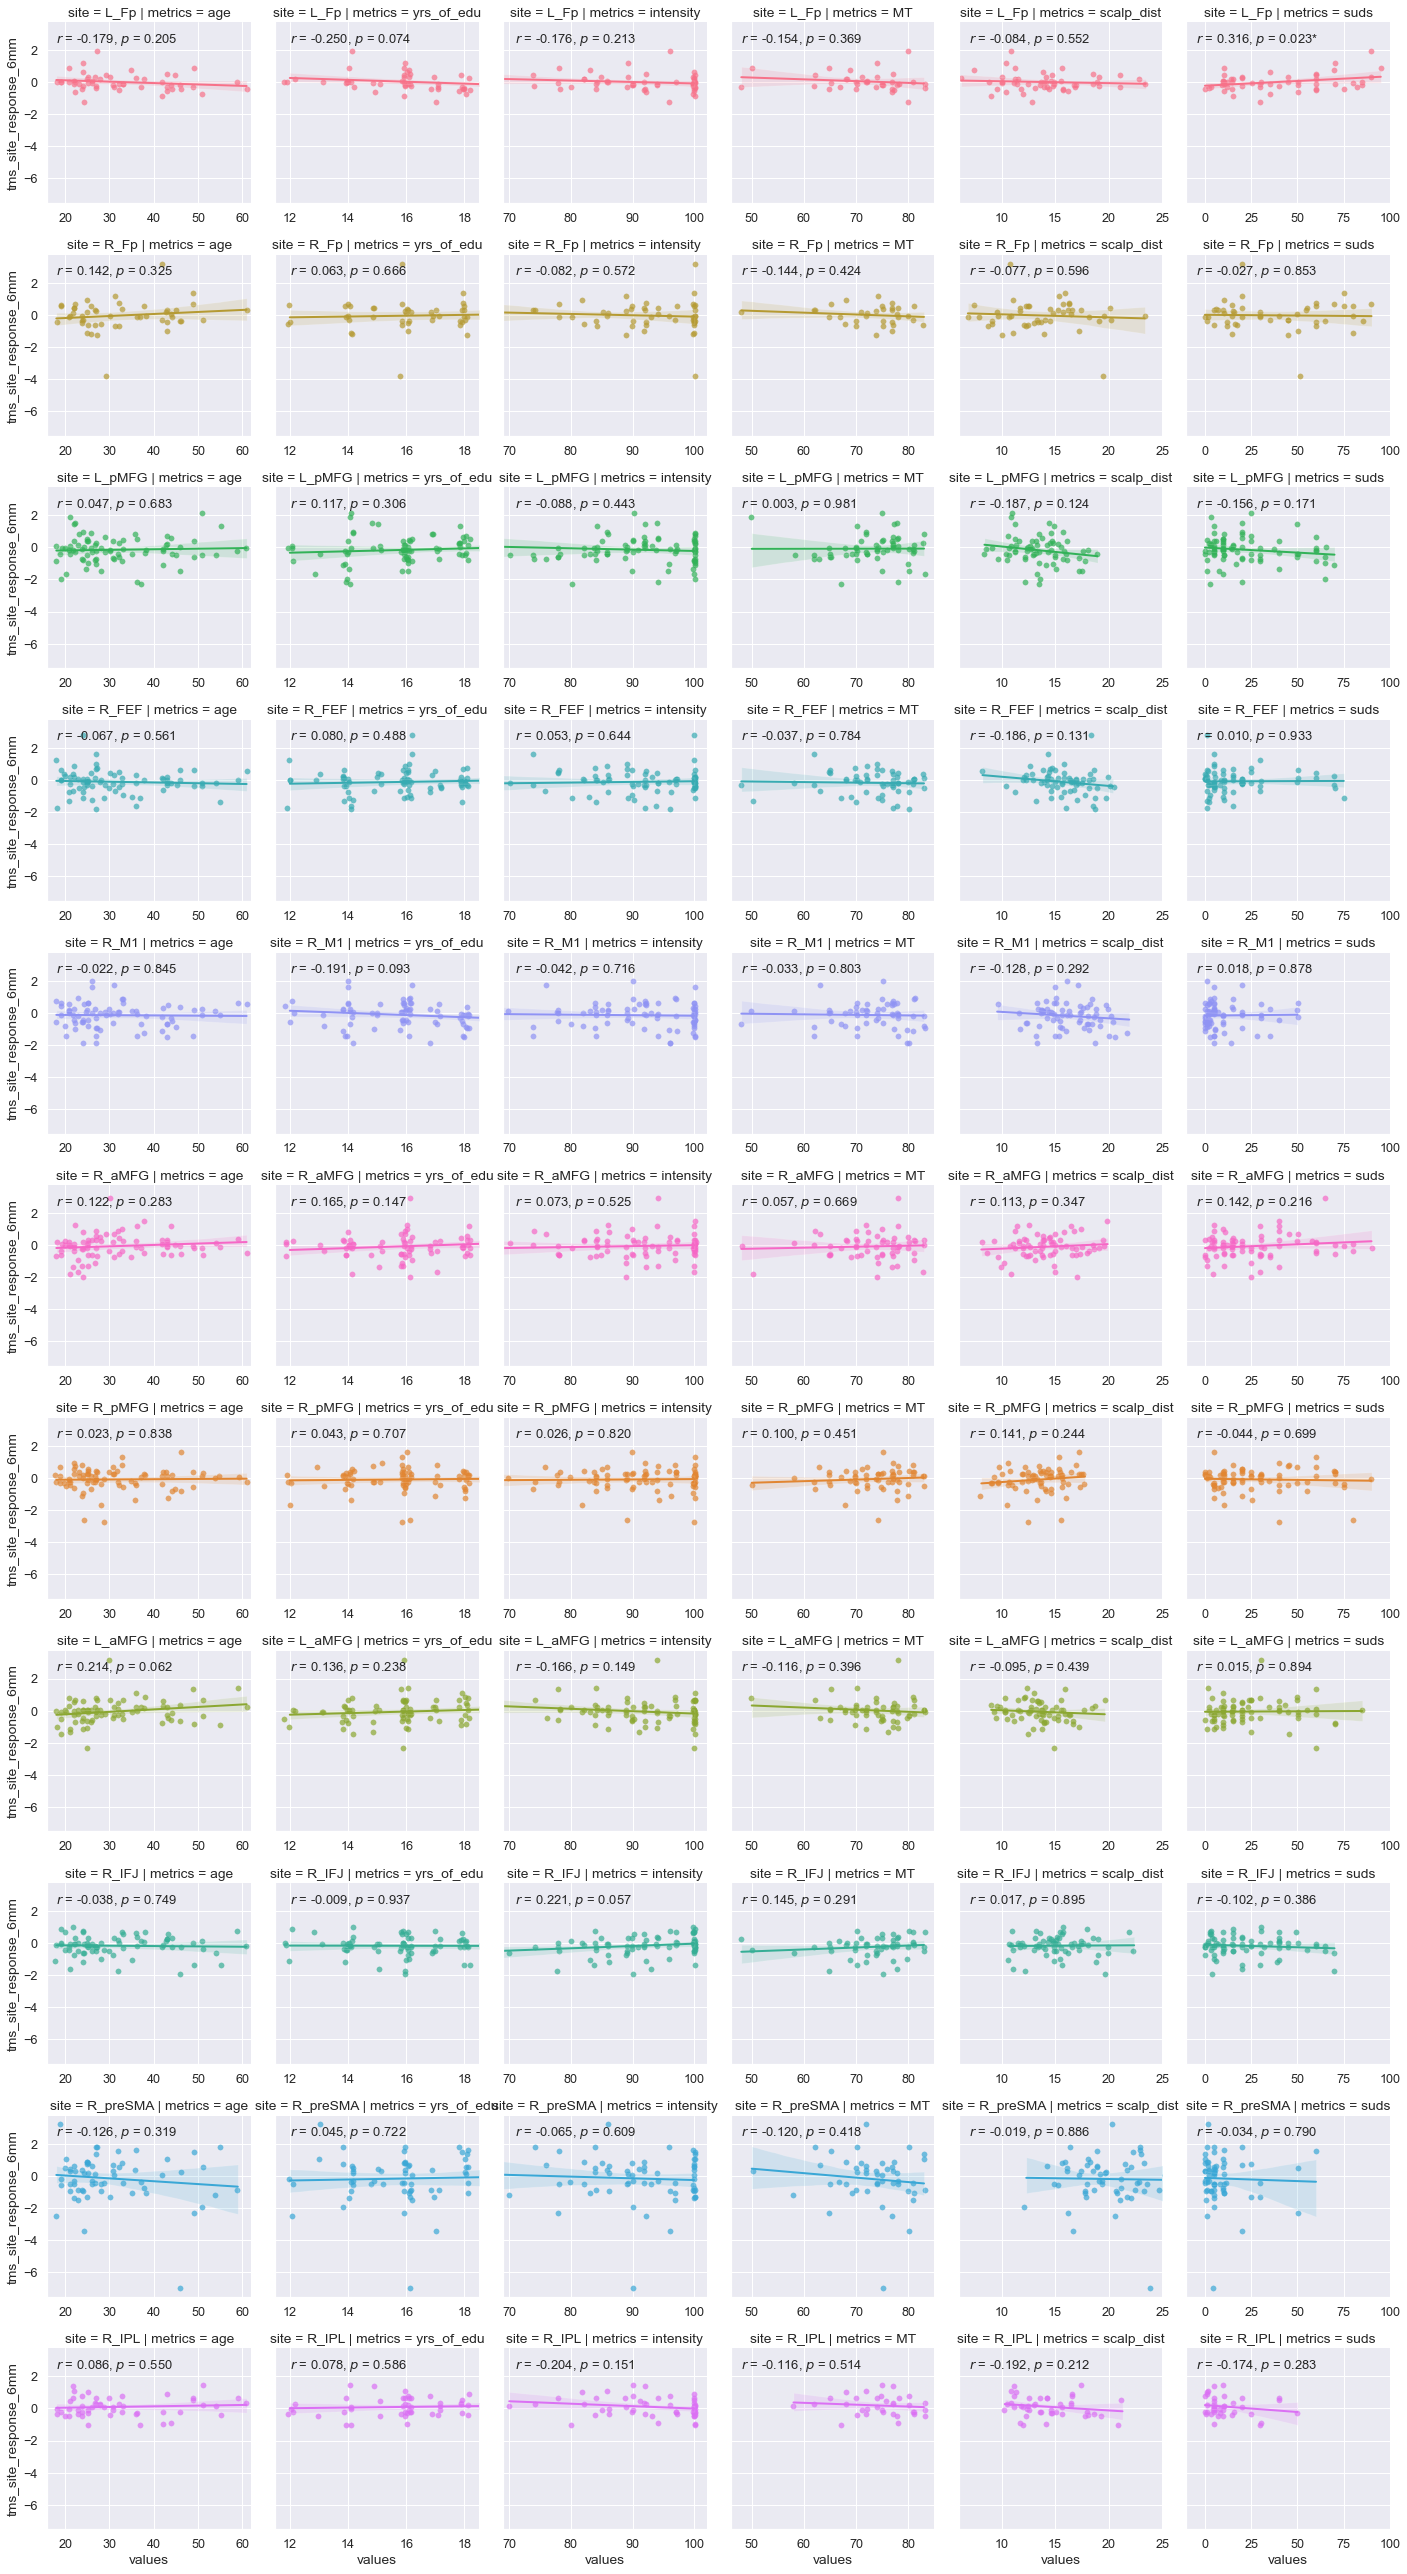

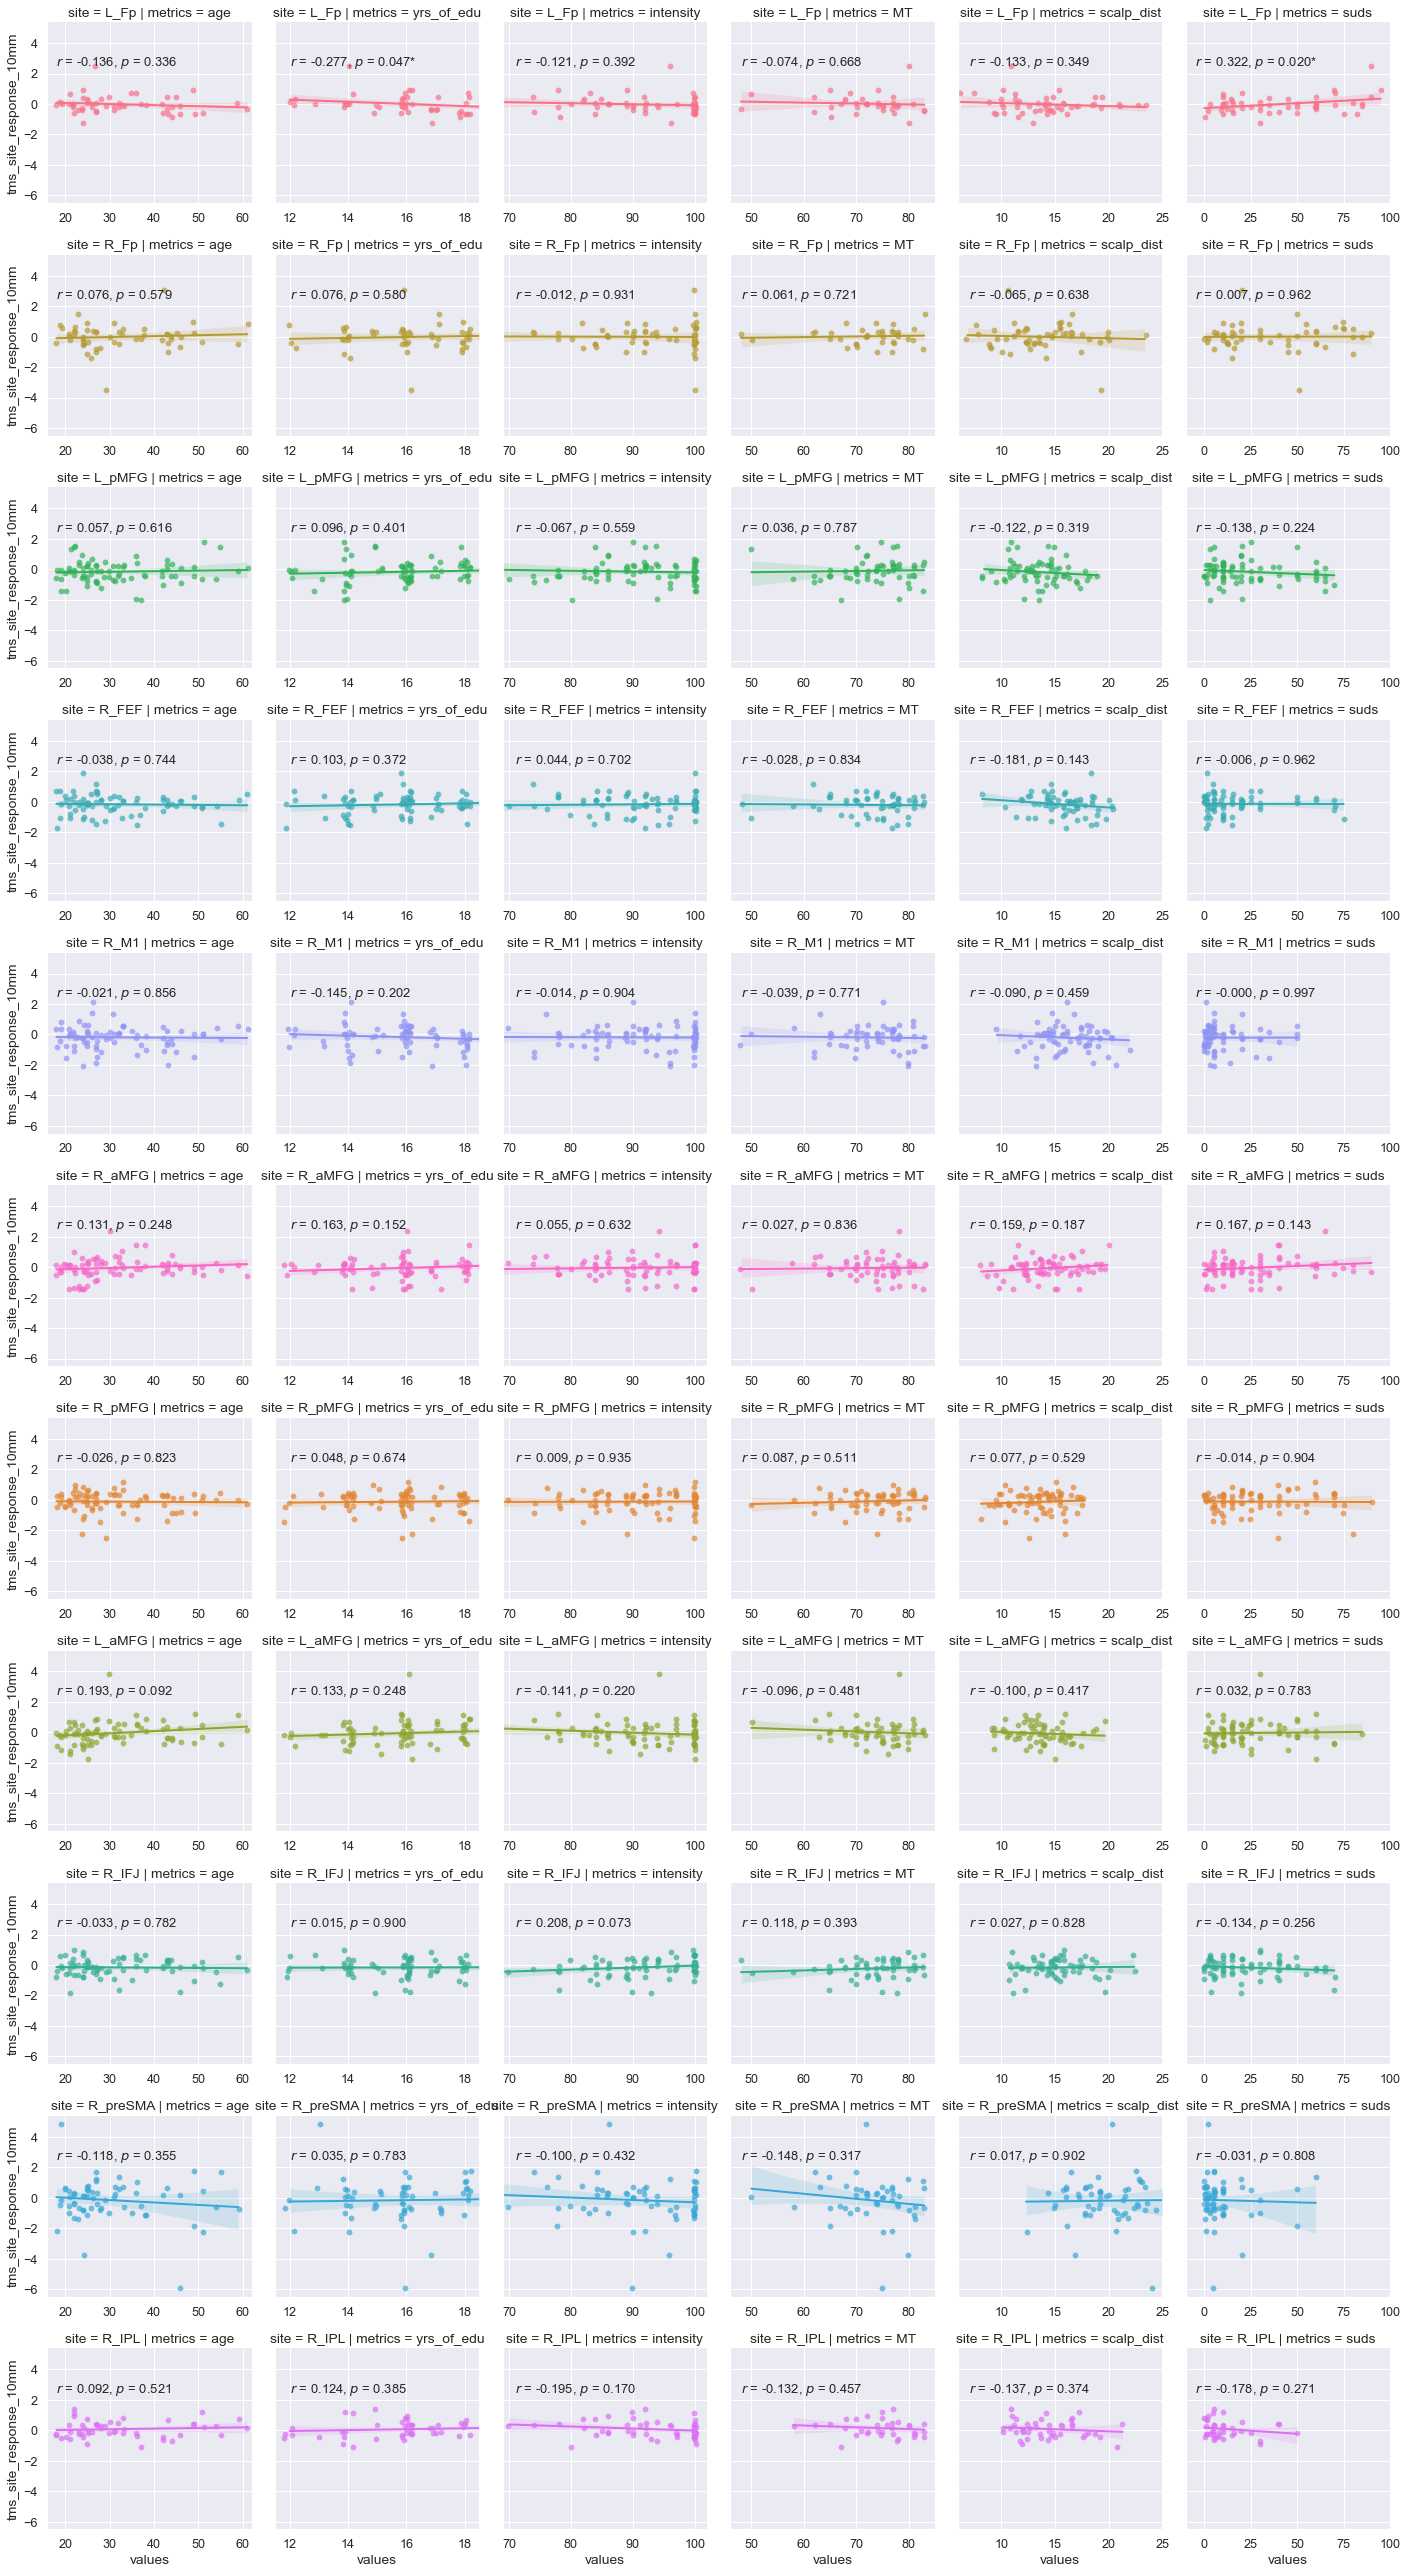

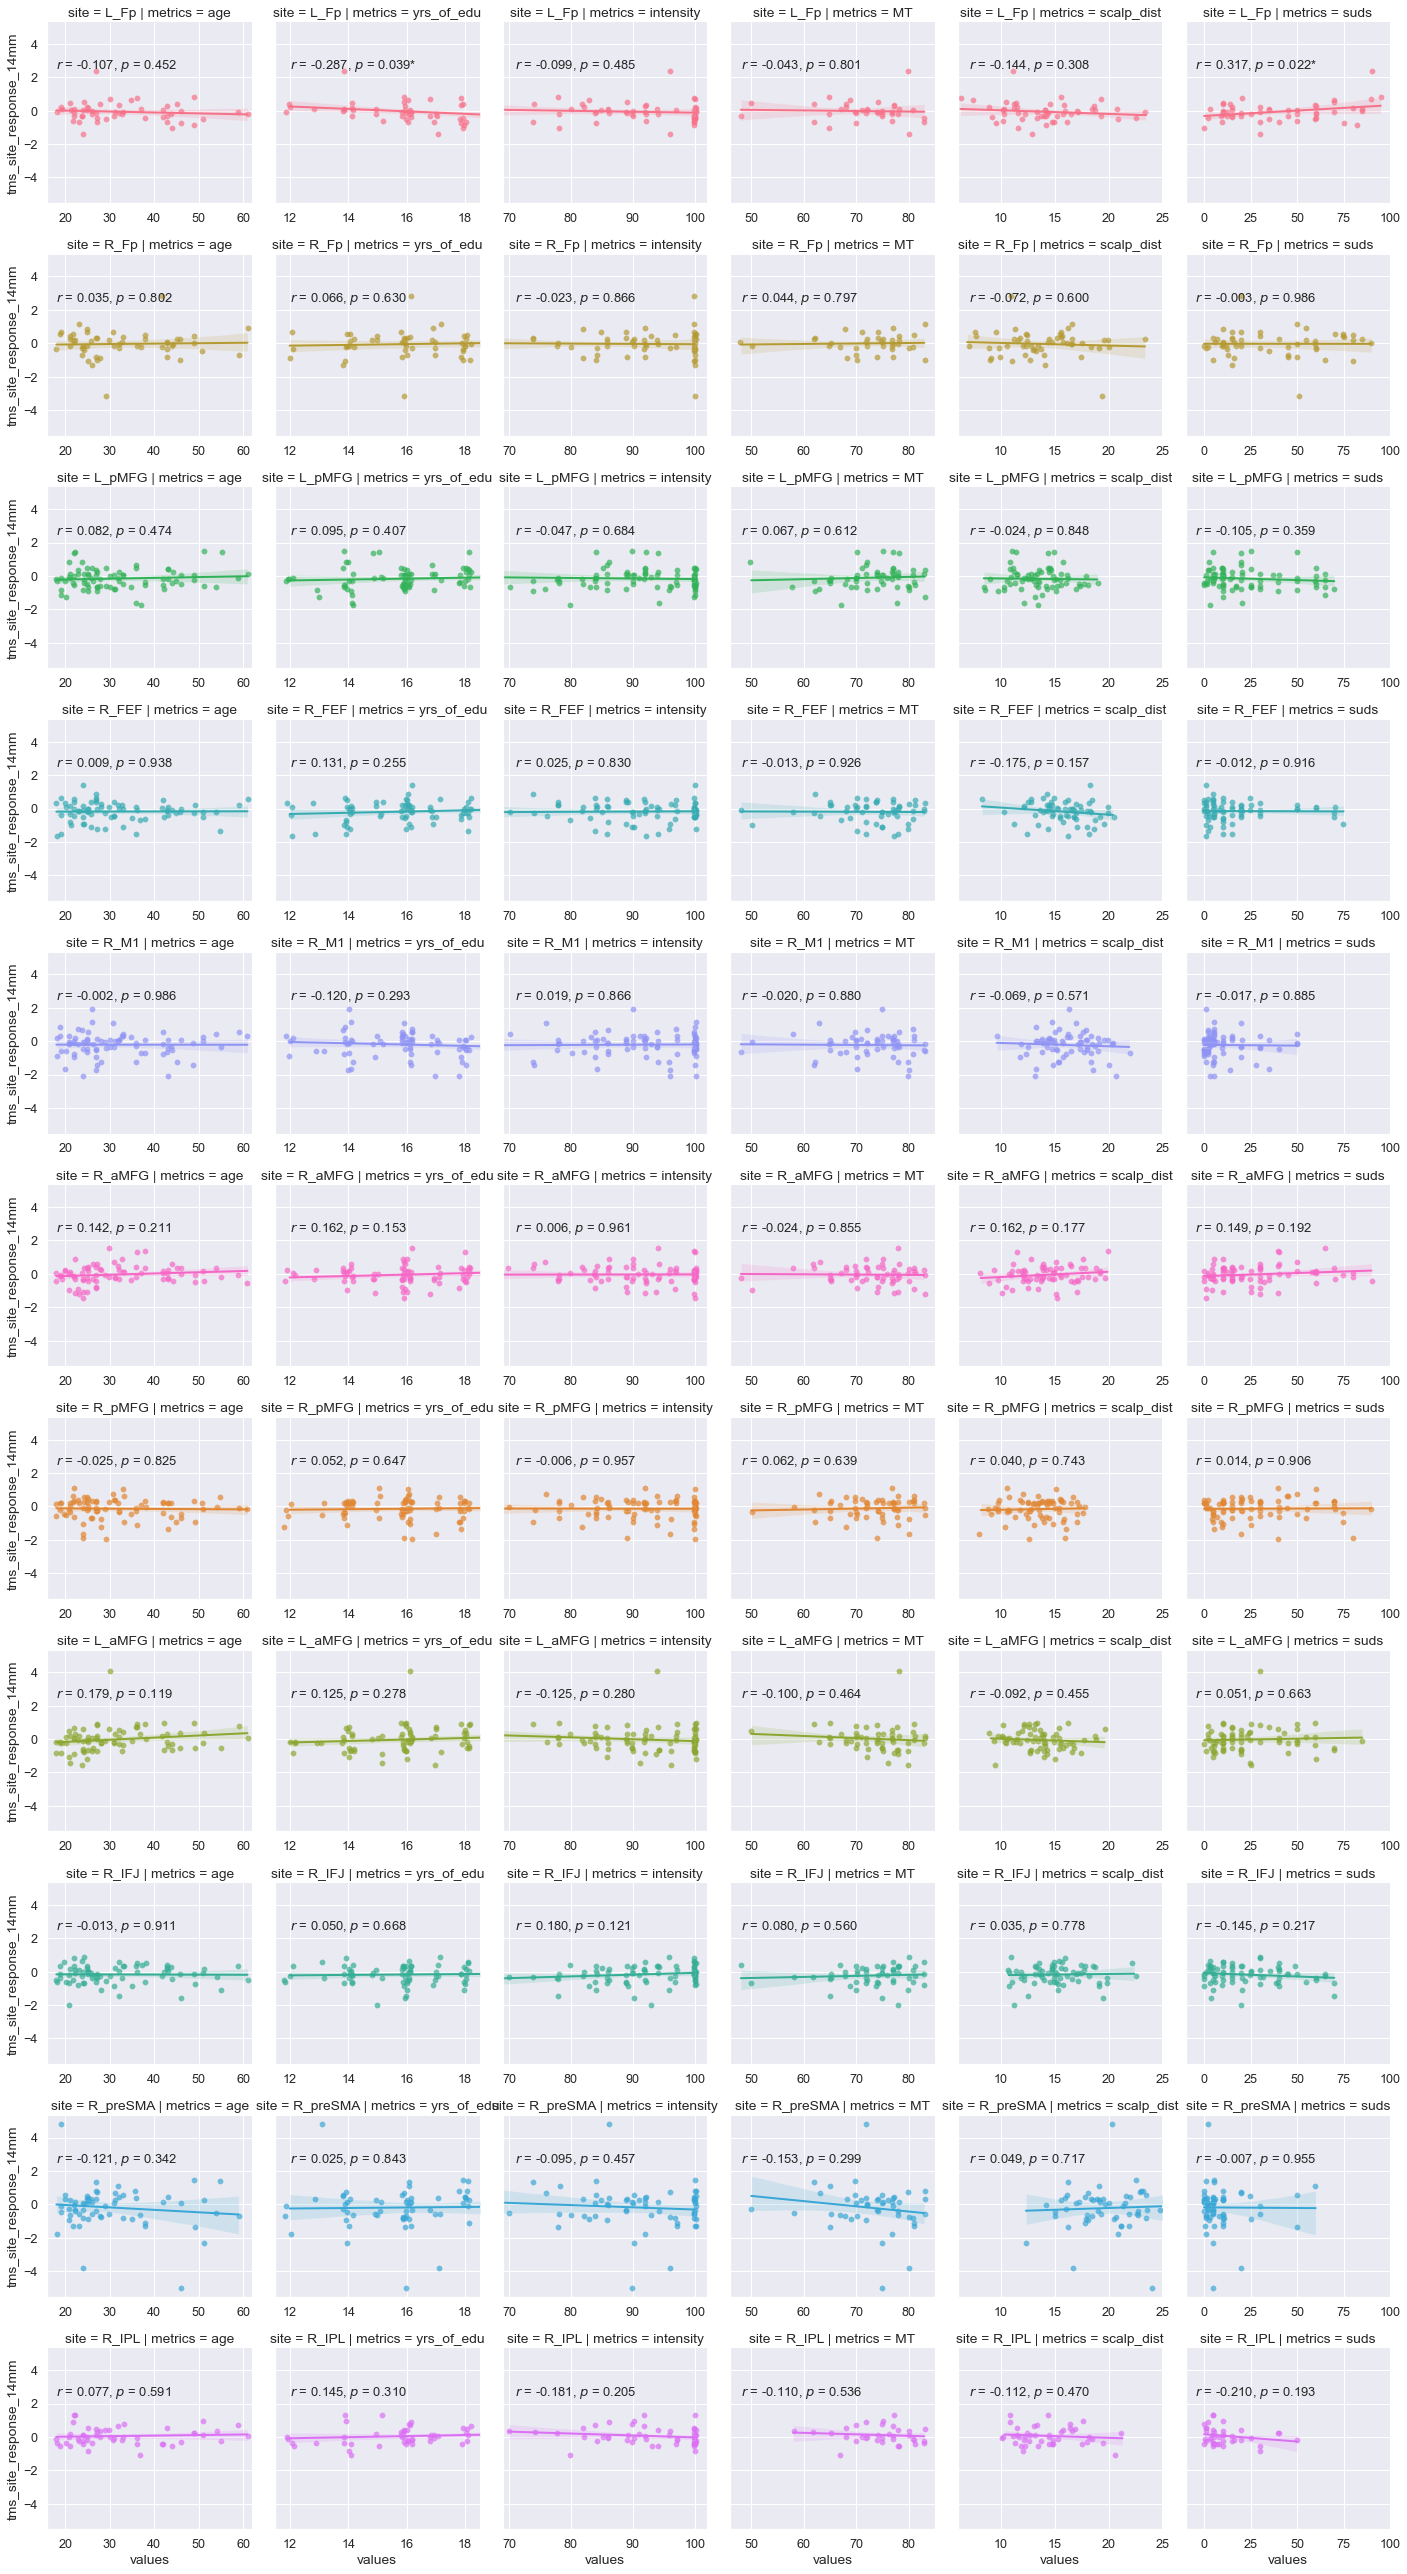

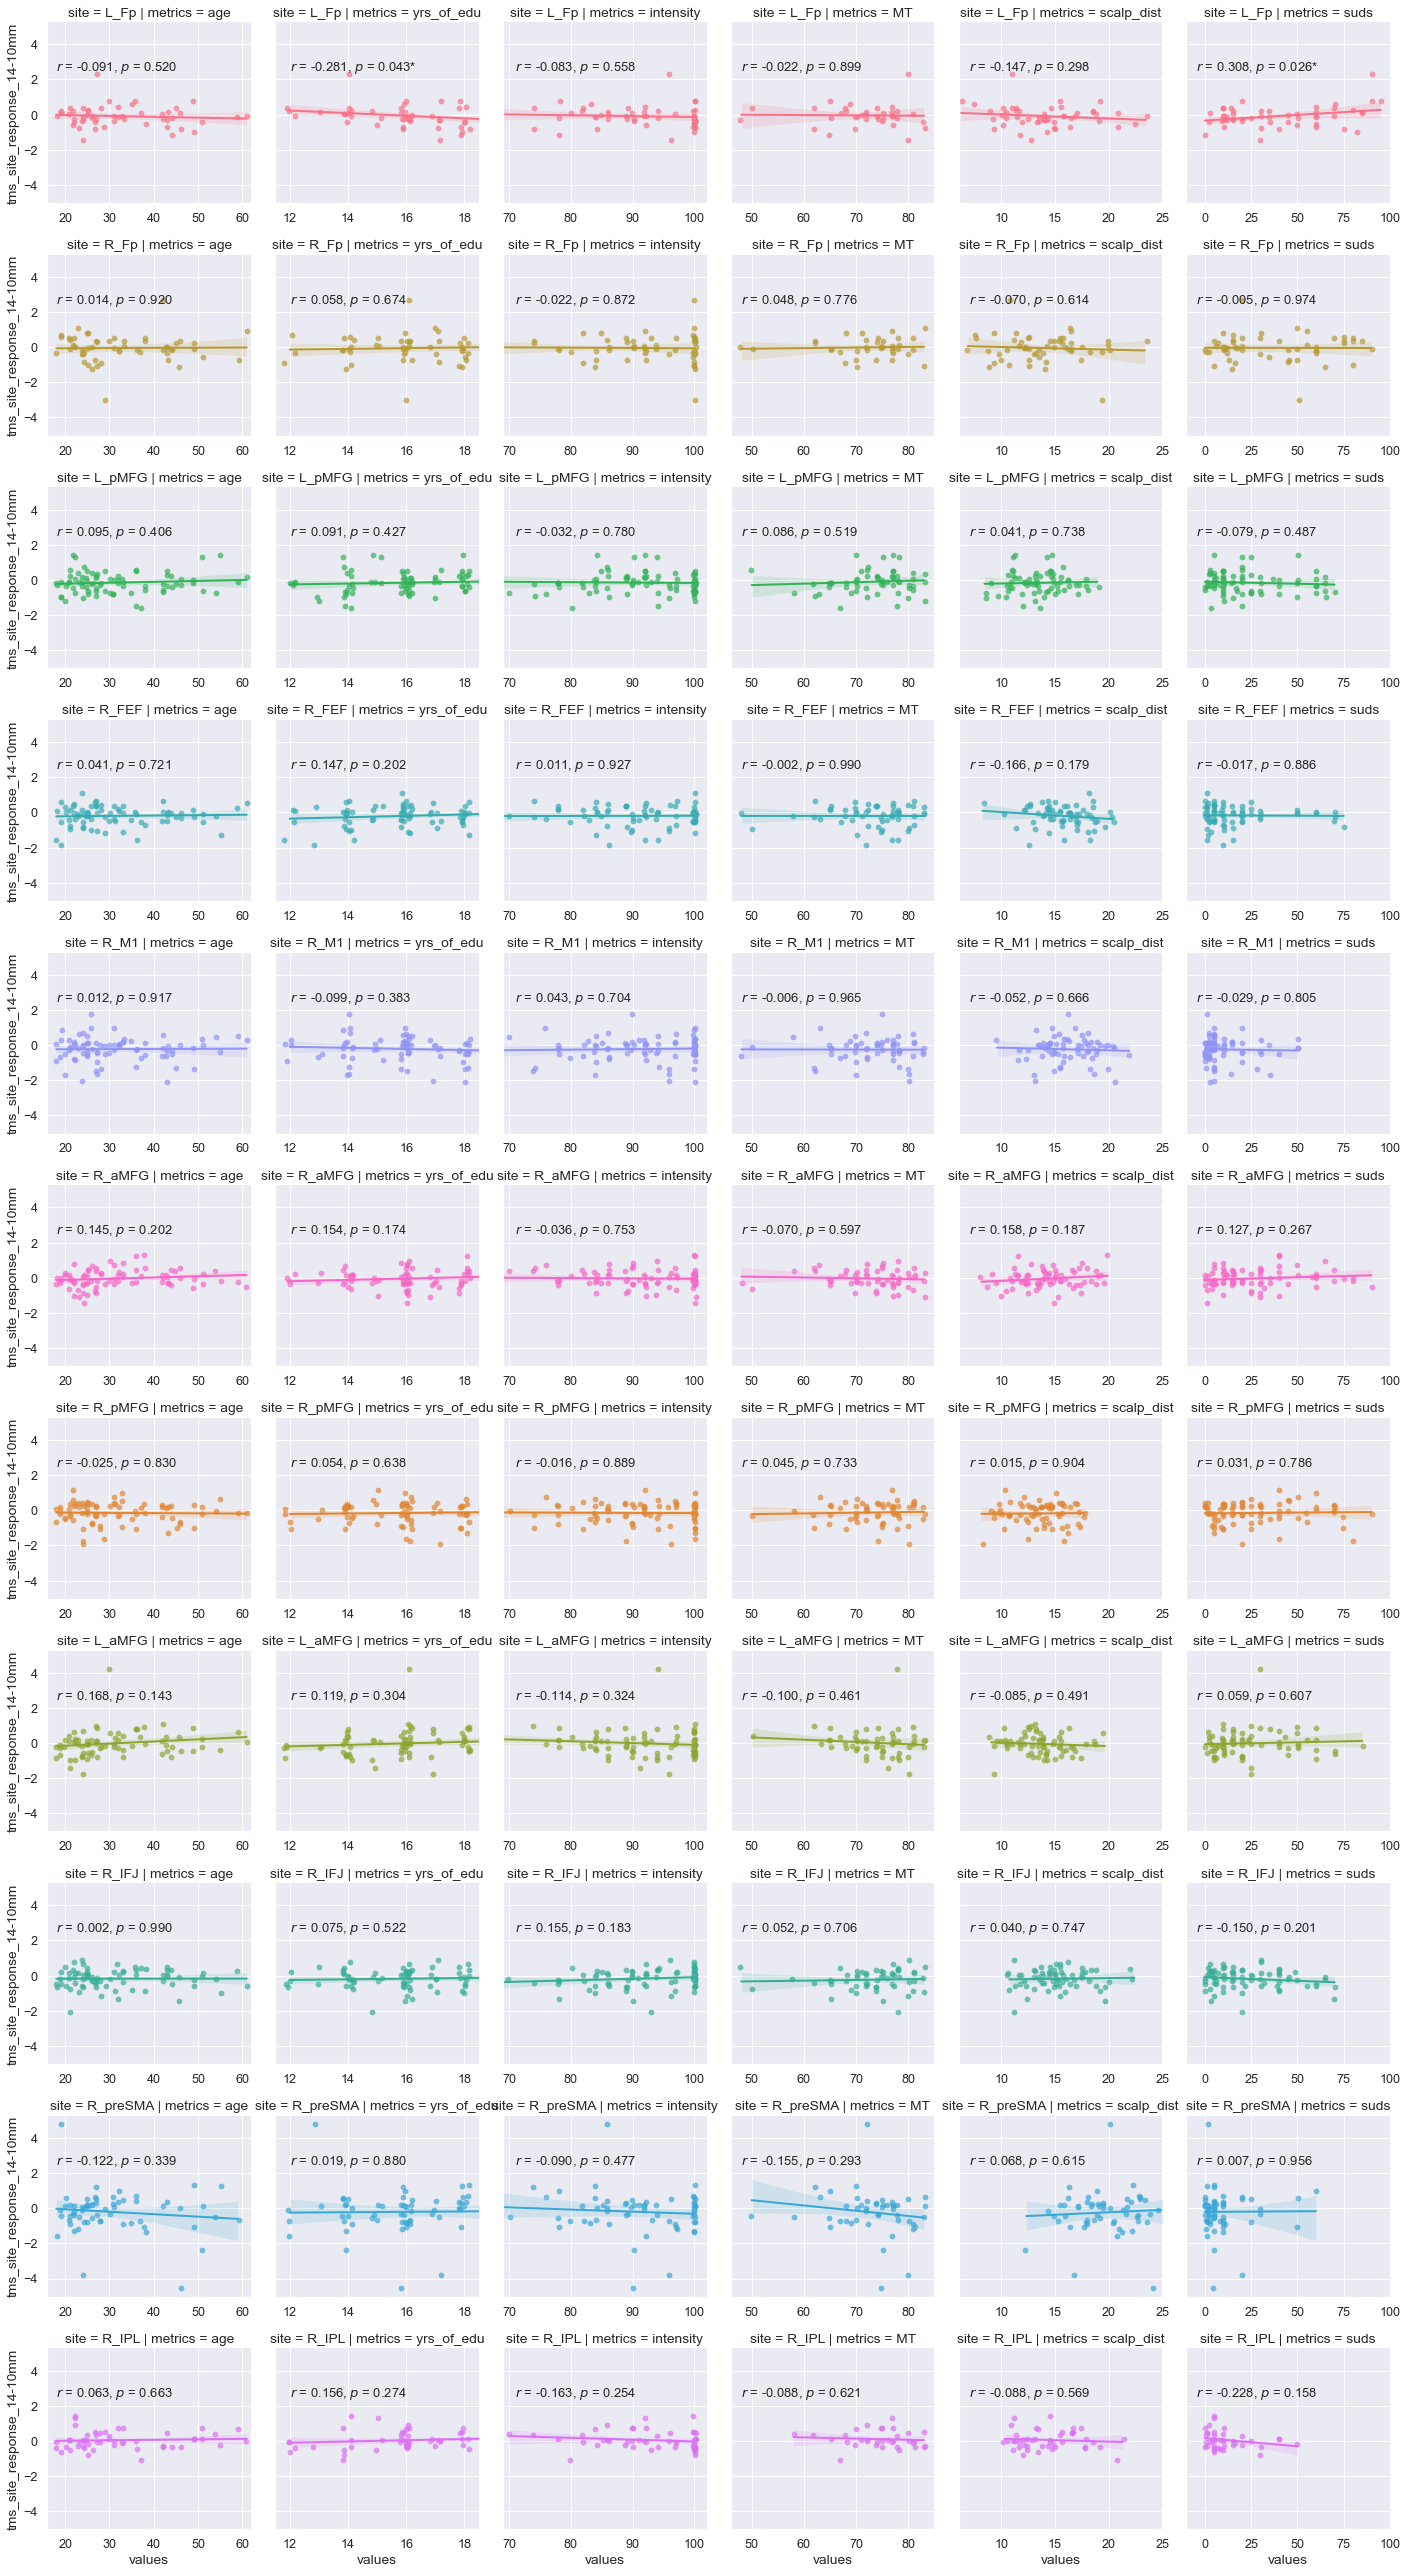

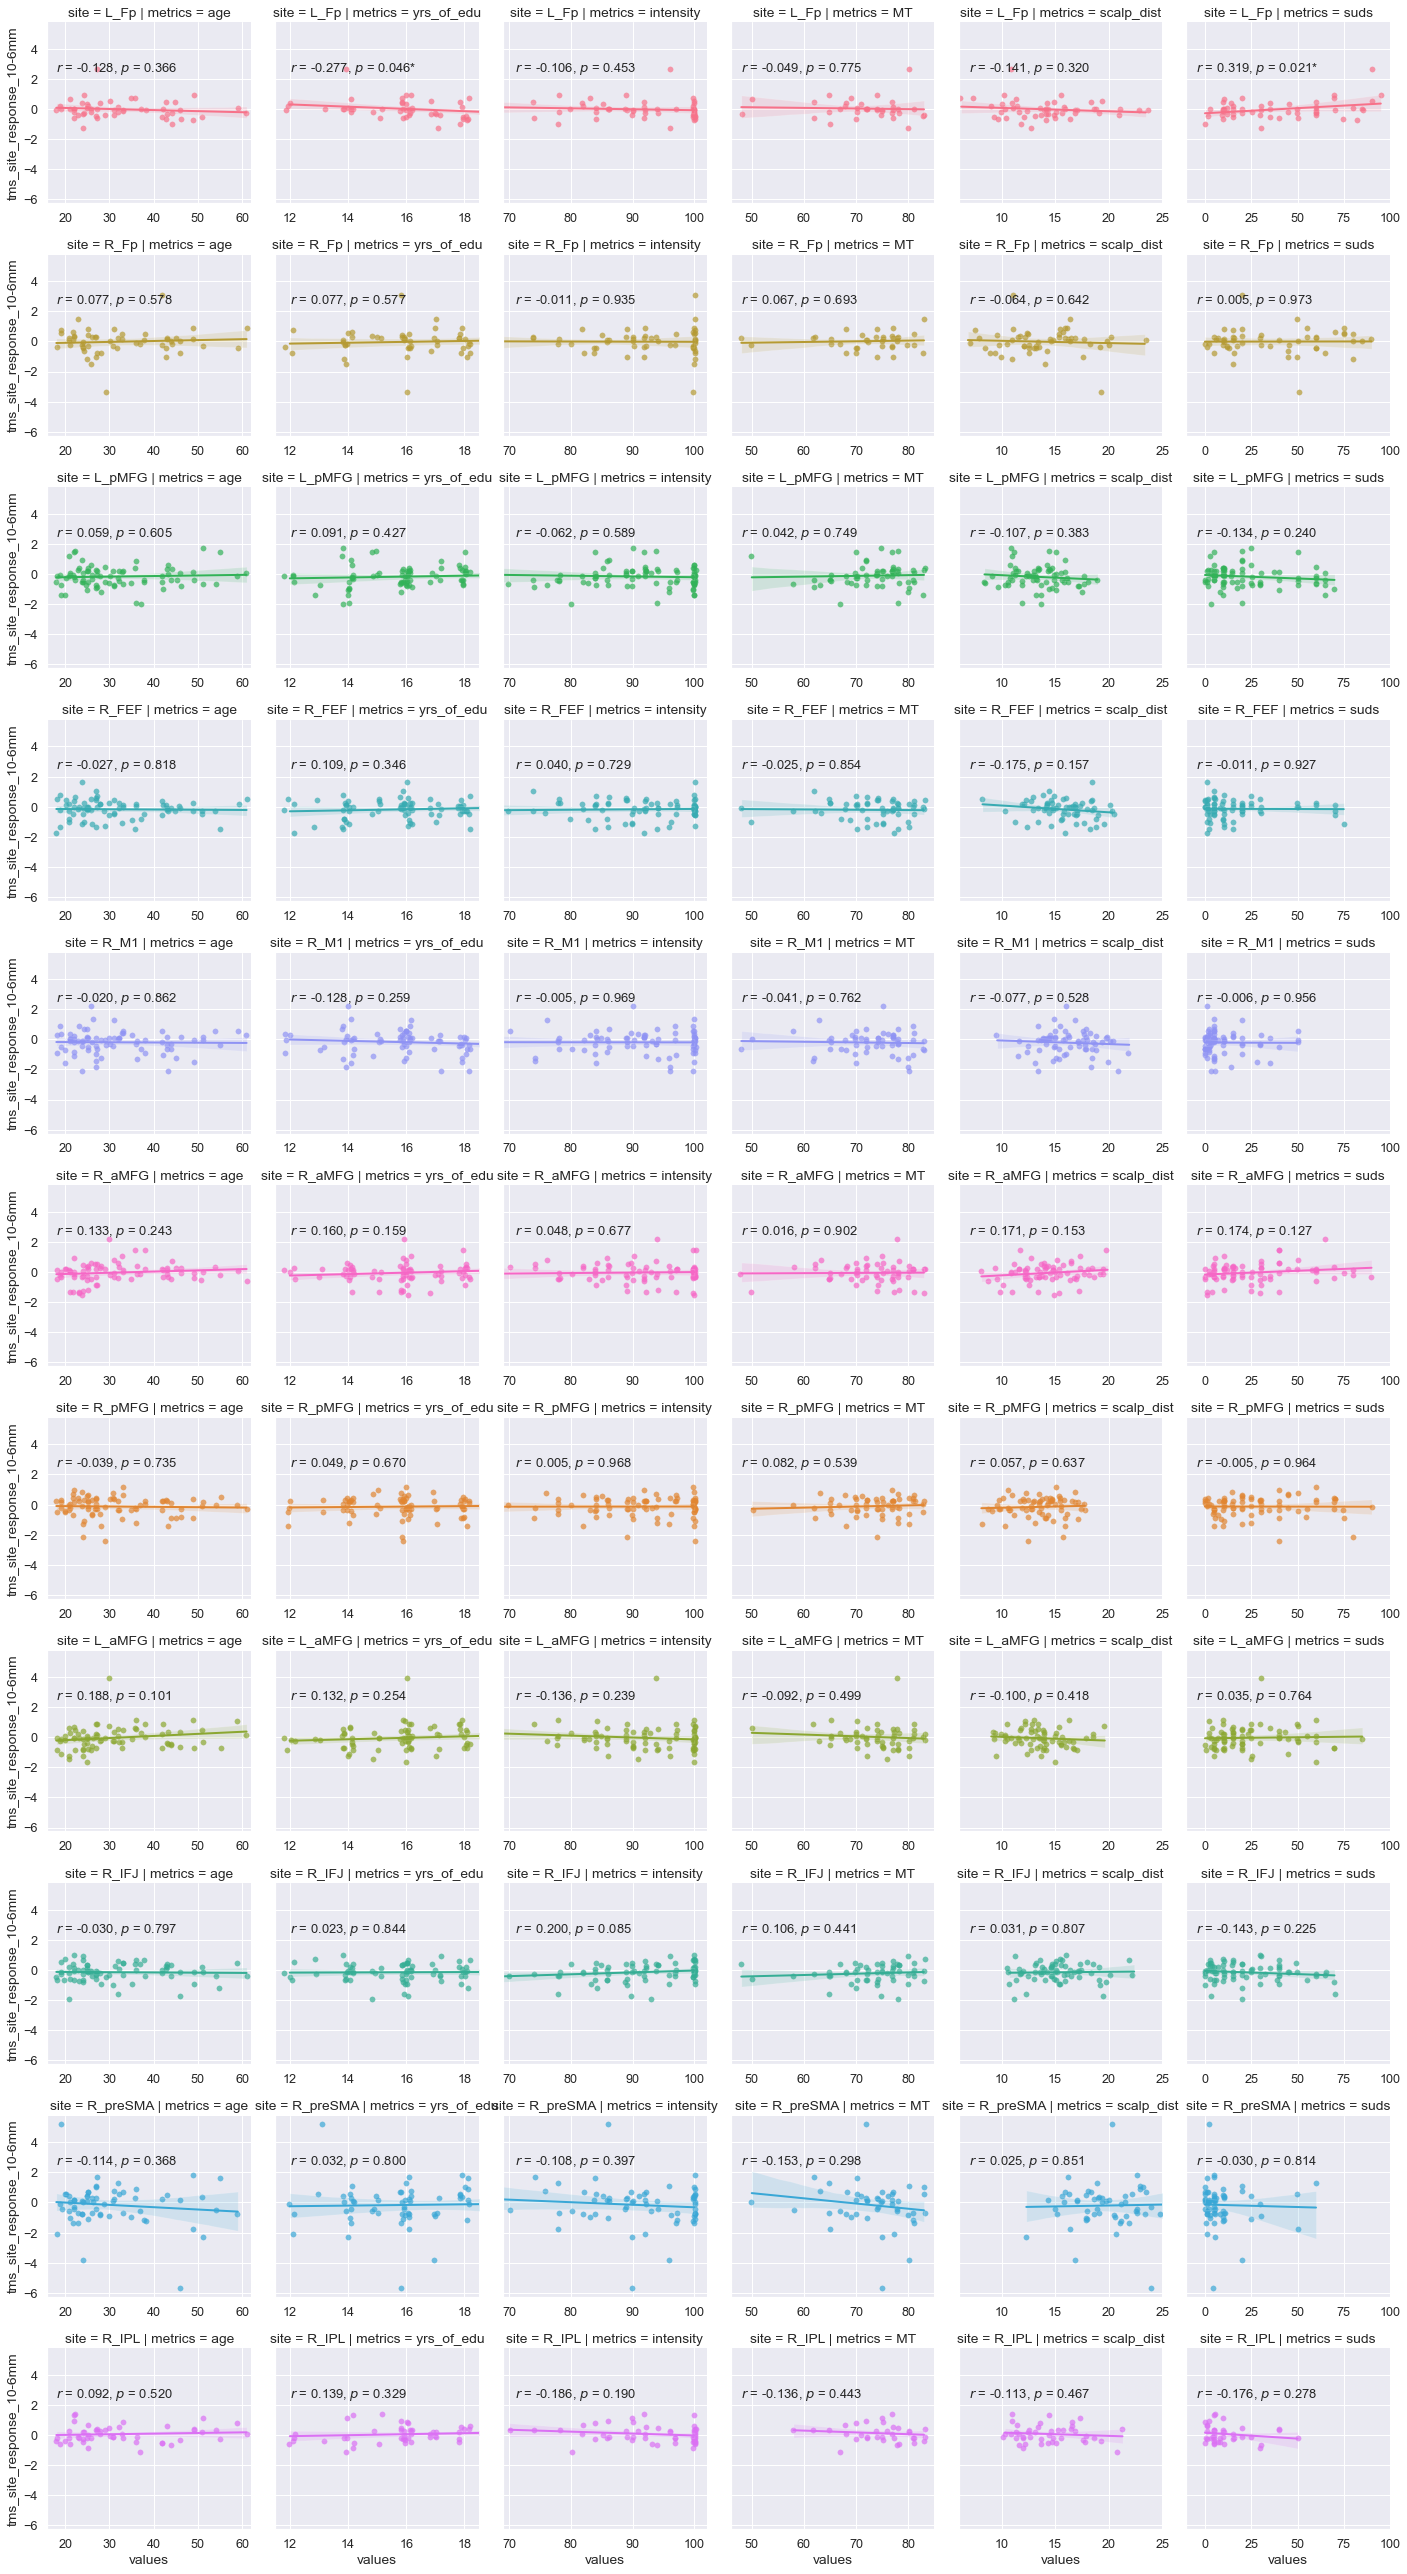

In [8]:
# don't display figures
# %%capture

for var in test_variables:
    f = scatter_plot(plot_data, var)
    f.savefig(out_dir+'/figure2_scatter_plots' + var + '.png', 
              dpi=600, bbox_inches = 'tight', pad_inches = 0.1)
    